## ignite

https://docs.pytorch.org/ignite/
https://github.com/pytorch/ignite

In [18]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

from ignite.engine import Engine, Events
from ignite.metrics import Accuracy, Loss, Precision, Recall, ConfusionMatrix, Fbeta
from ignite.contrib.handlers import ProgressBar
import matplotlib.pyplot as plt

In [3]:
# --------#--------------------
# 설정
# ----------------------------
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
batch_size = 64
learning_rate = 0.001
num_epochs = 5
num_classes = 10

In [33]:
# ----------------------------
# 데이터 로딩
# ----------------------------
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
val_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

In [34]:
# ----------------------------
# 모델 정의
# ----------------------------
model = nn.Sequential(
    nn.Flatten(),
    nn.Linear(28 * 28, 128),
    nn.ReLU(),
    nn.Linear(128, num_classes)
).to(device)

In [35]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

In [36]:
#----------------------------
# 학습 엔진 정의
# ----------------------------
def train_step(engine, batch):
    model.train()
    x, y = batch
    x, y = x.to(device), y.to(device)

    optimizer.zero_grad()
    y_pred = model(x)
    loss = criterion(y_pred, y)
    loss.backward()
    optimizer.step()

    return y_pred, y

trainer = Engine(train_step)

In [50]:
# ----------------------------
# 검증 엔진 정의
# ----------------------------
def val_step(engine, batch):
    model.eval()
    with torch.no_grad():
        x, y = batch
        x, y = x.to(device), y.to(device)
        y_pred = model(x)
        return y_pred, y

evaluator = Engine(val_step)

In [51]:
# ----------------------------
# 메트릭 정의 및 부착
# ----------------------------
for engine in [trainer, evaluator]:
    Accuracy().attach(engine, "accuracy")
    Loss(criterion).attach(engine, "loss")

In [52]:
# val 전용 메트릭
Precision(average=True).attach(evaluator, "precision")
Recall(average=True).attach(evaluator, "recall")
Fbeta(beta=1.0, average=True).attach(evaluator, "f1")
ConfusionMatrix(num_classes=num_classes).attach(evaluator, "confusion_matrix")

In [48]:
# 진행 바
ProgressBar().attach(trainer)

In [54]:
# ----------------------------
# 기록 리스트
# ----------------------------
train_losses, val_losses = [], []
train_accuracies, val_accuracies = [], []
val_precisions, val_recalls, val_f1s = [], [], []

In [55]:
# ----------------------------
# Epoch 종료 시 출력 및 저장
# ----------------------------
@trainer.on(Events.EPOCH_COMPLETED)
def log_metrics(engine):
    # Train
    train_metrics = engine.state.metrics
    train_losses.append(train_metrics["loss"])
    train_accuracies.append(train_metrics["accuracy"])

    # Validation
    evaluator.run(val_loader)
    val_metrics = evaluator.state.metrics
    val_losses.append(val_metrics["loss"])
    val_accuracies.append(val_metrics["accuracy"])
    val_precisions.append(val_metrics["precision"])
    val_recalls.append(val_metrics["recall"])
    val_f1s.append(val_metrics["f1"])

    print(f"\n[Epoch {engine.state.epoch}]")
    print(f"Train Loss: {train_metrics['loss']:.4f} | Train Acc: {train_metrics['accuracy']:.4f}")
    print(f"Val   Loss: {val_metrics['loss']:.4f} | Val Acc:   {val_metrics['accuracy']:.4f}")
    print(f"Val   Precision: {val_metrics['precision']:.4f} | Recall: {val_metrics['recall']:.4f} | F1: {val_metrics['f1']:.4f}")
    print(f"Confusion Matrix:\n{val_metrics['confusion_matrix'].cpu().numpy()}")


In [57]:
# ----------------------------
# 학습 시작
# ----------------------------
trainer.run(train_loader, max_epochs=num_epochs)


[1/938]   0%|           [00:00<?]

[1/938]   0%|           [00:00<?]


[Epoch 2]
Train Loss: 0.1113 | Train Acc: 0.9667
Val   Loss: 0.0934 | Val Acc:   0.9706
Val   Precision: 0.9705 | Recall: 0.9703 | F1: 0.9703
Confusion Matrix:
[[ 968    1    1    0    3    1    3    2    1    0]
 [   0 1126    2    1    0    1    2    1    2    0]
 [   5    3 1006    2    3    0    2    5    6    0]
 [   0    1    6  983    0    5    1    6    7    1]
 [   2    0    3    0  961    0    4    3    2    7]
 [   3    1    0   12    2  864    4    1    3    2]
 [   4    3    2    1    7   10  927    0    4    0]
 [   0    6   12    4    1    2    0  999    0    4]
 [   3    3    3    9    4    8    3    4  936    1]
 [   3    6    0   12   25   12    0   11    4  936]]

[Epoch 2]
Train Loss: 0.1113 | Train Acc: 0.9667
Val   Loss: 0.0934 | Val Acc:   0.9706
Val   Precision: 0.9705 | Recall: 0.9703 | F1: 0.9703
Confusion Matrix:
[[ 968    1    1    0    3    1    3    2    1    0]
 [   0 1126    2    1    0    1    2    1    2    0]
 [   5    3 1006    2    3    0    2    5

[1/938]   0%|           [00:00<?]

[1/938]   0%|           [00:00<?]


[Epoch 3]
Train Loss: 0.0787 | Train Acc: 0.9758
Val   Loss: 0.0877 | Val Acc:   0.9728
Val   Precision: 0.9725 | Recall: 0.9727 | F1: 0.9725
Confusion Matrix:
[[ 969    1    1    0    1    2    2    0    1    3]
 [   0 1129    0    0    0    1    3    0    2    0]
 [   7    2  993    4    5    0    5    6   10    0]
 [   1    0    1  973    1   14    0    7    5    8]
 [   2    0    2    0  965    0    2    2    3    6]
 [   3    0    0    3    1  876    7    0    1    1]
 [   6    3    0    1    5    6  937    0    0    0]
 [   2    9    8    1    0    1    0  978    1   28]
 [   7    0    3    3    3   13    4    3  933    5]
 [   2    4    0    4   12   11    0    0    1  975]]

[Epoch 3]
Train Loss: 0.0787 | Train Acc: 0.9758
Val   Loss: 0.0877 | Val Acc:   0.9728
Val   Precision: 0.9725 | Recall: 0.9727 | F1: 0.9725
Confusion Matrix:
[[ 969    1    1    0    1    2    2    0    1    3]
 [   0 1129    0    0    0    1    3    0    2    0]
 [   7    2  993    4    5    0    5    6

[1/938]   0%|           [00:00<?]

[1/938]   0%|           [00:00<?]


[Epoch 4]
Train Loss: 0.0583 | Train Acc: 0.9813
Val   Loss: 0.0826 | Val Acc:   0.9737
Val   Precision: 0.9736 | Recall: 0.9734 | F1: 0.9735
Confusion Matrix:
[[ 966    0    2    1    2    2    3    1    1    2]
 [   0 1124    5    1    0    1    2    0    2    0]
 [   4    0 1009    5    1    0    4    6    3    0]
 [   0    0    5  988    0    2    0    5    3    7]
 [   3    0    3    0  960    0    7    3    2    4]
 [   1    0    0   18    1  861    5    1    3    2]
 [   3    3    1    1    3    5  940    0    2    0]
 [   1    4    9    3    0    0    0 1002    3    6]
 [   3    0    9    6    4    8    2    4  936    2]
 [   0    5    0    9   22    4    0    7   11  951]]

[Epoch 4]
Train Loss: 0.0583 | Train Acc: 0.9813
Val   Loss: 0.0826 | Val Acc:   0.9737
Val   Precision: 0.9736 | Recall: 0.9734 | F1: 0.9735
Confusion Matrix:
[[ 966    0    2    1    2    2    3    1    1    2]
 [   0 1124    5    1    0    1    2    0    2    0]
 [   4    0 1009    5    1    0    4    6

[1/938]   0%|           [00:00<?]

[1/938]   0%|           [00:00<?]


[Epoch 5]
Train Loss: 0.0457 | Train Acc: 0.9854
Val   Loss: 0.0754 | Val Acc:   0.9772
Val   Precision: 0.9770 | Recall: 0.9771 | F1: 0.9770
Confusion Matrix:
[[ 973    1    1    0    0    3    0    0    1    1]
 [   0 1126    1    2    0    1    2    0    3    0]
 [   6    2  995    3    1    0    5    5   14    1]
 [   1    0    3  991    0    6    0    3    4    2]
 [   3    0    0    1  961    0    3    3    0   11]
 [   1    0    0   11    1  874    1    1    2    1]
 [   4    2    0    1    6    7  933    1    4    0]
 [   2    5    4    5    0    1    0  987    4   20]
 [   5    0    2    4    2    6    0    4  948    3]
 [   3    3    0    3    6    8    0    2    0  984]]

[Epoch 5]
Train Loss: 0.0457 | Train Acc: 0.9854
Val   Loss: 0.0754 | Val Acc:   0.9772
Val   Precision: 0.9770 | Recall: 0.9771 | F1: 0.9770
Confusion Matrix:
[[ 973    1    1    0    0    3    0    0    1    1]
 [   0 1126    1    2    0    1    2    0    3    0]
 [   6    2  995    3    1    0    5    5

State:
	iteration: 4690
	epoch: 5
	epoch_length: 938
	max_epochs: 5
	output: <class 'tuple'>
	batch: <class 'list'>
	metrics: <class 'dict'>
	dataloader: <class 'torch.utils.data.dataloader.DataLoader'>
	seed: <class 'NoneType'>
	times: <class 'dict'>

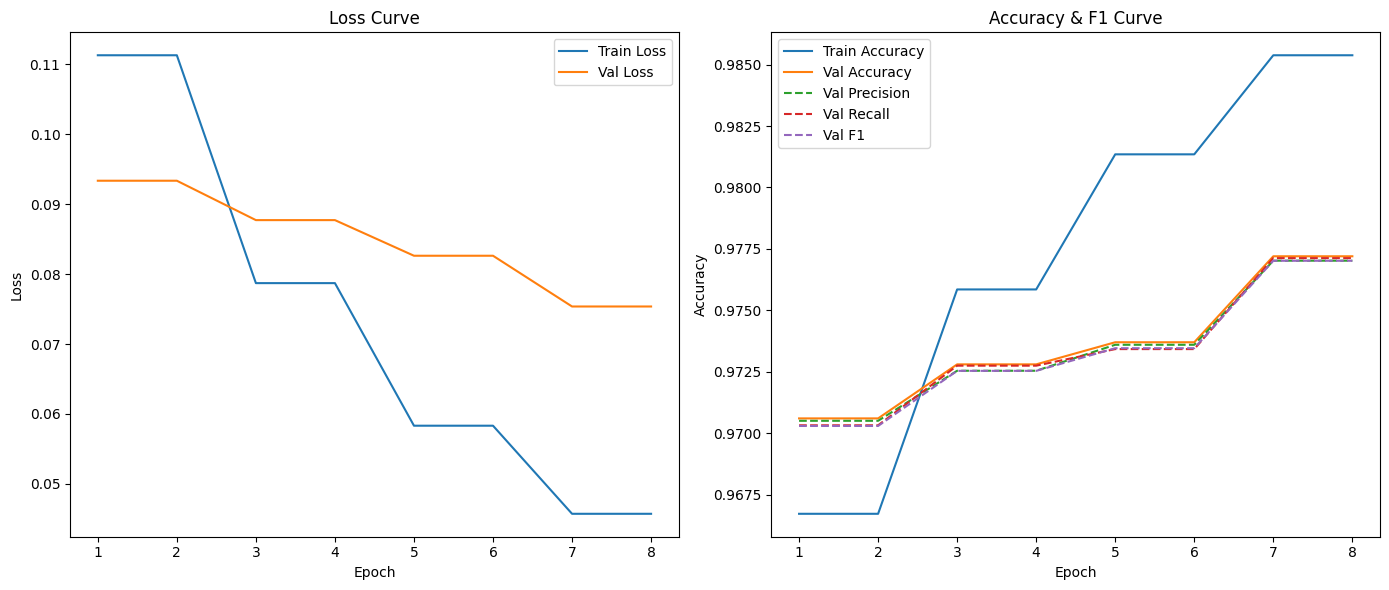

In [67]:
# ----------------------------
# 결과 시각화
# ----------------------------
epochs = list(range(1, len(train_losses) + 1))

plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
plt.plot(epochs, train_losses, label="Train Loss")
plt.plot(epochs, val_losses, label="Val Loss")
plt.title("Loss Curve")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs, train_accuracies, label="Train Accuracy")
plt.plot(epochs, val_accuracies, label="Val Accuracy")
plt.plot(epochs, val_precisions, label="Val Precision", linestyle='--')
plt.plot(epochs, val_recalls, label="Val Recall", linestyle='--')
plt.plot(epochs, val_f1s, label="Val F1", linestyle='--')
plt.title("Accuracy & F1 Curve")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()

plt.tight_layout()
plt.show()

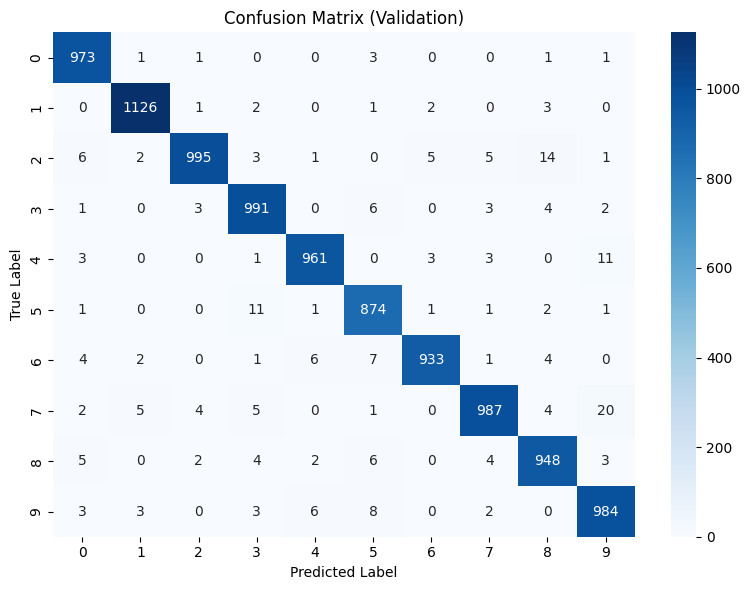

In [66]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# 1. Confusion matrix 가져오기
conf_matrix = evaluator.state.metrics["confusion_matrix"].cpu().numpy()

# 2. 클래스 라벨 (MNIST: 0~9)
class_labels = [str(i) for i in range(10)]

# 3. 시각화
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues",
            xticklabels=class_labels, yticklabels=class_labels)

plt.title("Confusion Matrix (Validation)")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.tight_layout()
plt.show()
